In [1]:
import os, sys
from pathlib import Path

def find_project_root(marker_dirs=('src','data')):
    p = Path().resolve()
    while True:
        if all((p / d).is_dir() for d in marker_dirs):
            return p
        if p.parent == p:
            raise RuntimeError(f"Could not find project root containing {marker_dirs}")
        p = p.parent

project_root = find_project_root()
os.chdir(project_root)
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("✔️ Project root:", project_root)


✔️ Project root: /Users/LeoWang/Desktop/CU/Risk/Risk_Project


In [2]:
# ── Cell 2: Imports & Config ───────────────────────────────────────────────────
import pandas as pd
import numpy as np
from tqdm.notebook import trange
from scipy.stats   import chi2

from risk_project.config      import (
    STOCK_FILES,
    TARGET_NOTIONAL,
    P_VAR,
    HORIZON_DAYS,
    WINDOW,
    BACKTEST_START,
    BACKTEST_END,
    TRADING_DAYS_YR,
    MC_PATHS,
    SEED
)
from risk_project.data_loader import load_price_series
from risk_project.var_es      import parametric_var_es, historical_var_es
from risk_project.monte_carlo import monte_carlo
from risk_project.backtest    import compute_portfolio_pnl, compute_exceptions, kupiec_test

print("Settings:")
print(f"  STOCK_FILES     = {STOCK_FILES}")
print(f"  TARGET_NOTIONAL = {TARGET_NOTIONAL}")
print(f"  P_VaR           = {P_VAR}")
print(f"  HORIZON_DAYS    = {HORIZON_DAYS}")
print(f"  WINDOW          = {WINDOW}")
print(f"  BACKTEST_START  = {BACKTEST_START}")
print(f"  BACKTEST_END    = {BACKTEST_END}")
print(f"  TRADING_DAYS_YR = {TRADING_DAYS_YR}")
print(f"  MC_PATHS, SEED  = {MC_PATHS}, {SEED}")


Settings:
  STOCK_FILES     = ['data/AAPL-bloomberg.csv', 'data/AMZN-bloomberg.csv']
  TARGET_NOTIONAL = 100000
  P_VaR           = 0.99
  HORIZON_DAYS    = 1
  WINDOW          = 250
  BACKTEST_START  = None
  BACKTEST_END    = None
  TRADING_DAYS_YR = 252
  MC_PATHS, SEED  = 10000, 42


In [3]:
# 1) Load price series into a dict of pd.Series
series   = load_price_series(STOCK_FILES)

# 2) Combine into single DataFrame & drop any dates with missing data
price_df = pd.DataFrame(series).dropna()

# 3) Build $-notional positions so each ticker has TARGET_NOTIONAL exposure
positions = {
    s: TARGET_NOTIONAL / price_df[s].iloc[-1]
    for s in price_df.columns
}

# 4) Compute realized P&L series (1-day horizon)
pnl = compute_portfolio_pnl(series, positions, horizon_days=HORIZON_DAYS)

print("Price DataFrame head:")
display(price_df.head())
print("Positions (shares):", positions)
print("P&L head:")
display(pnl.head())


Price DataFrame head:


,AAPL,AMZN
Dates,,
1997-05-15,0.158,0.098
1997-05-16,0.154,0.086
1997-05-19,0.152,0.085
1997-05-20,0.154,0.082
1997-05-21,0.151,0.071


Positions (shares): {'AAPL': 429.88565041698905, 'AMZN': 429.6270836913559}
P&L head:


Dates
1982-11-16   -3.009200
1982-11-17    2.579314
1982-11-18    0.000000
1982-11-19   -0.859771
1982-11-22   -3.439085
dtype: float64

In [4]:
# ── Cell 4: Rolling VaR Calculation (with proper per‐window calibration) ──
import pandas as pd
from tqdm.notebook    import trange
from risk_project.config       import P_VAR, HORIZON_DAYS, WINDOW, TRADING_DAYS_YR, MC_PATHS, SEED
from risk_project.calibration  import estimate_mu_sigma, estimate_covariance_matrix
from risk_project.var_es       import parametric_var_es, historical_var_es
from risk_project.monte_carlo  import monte_carlo

dates      = price_df.index
param_vars = []
hist_vars  = []
mc_vars    = []
roll_dates = []

for i in trange(WINDOW, len(dates)):
    # 1) window of history
    date       = dates[i]
    hist_slice = price_df.iloc[i-WINDOW : i]

    # 2a) Calibrate parametric drift & covariance on this window
    #    μ_ann: dict symbol→annual drift;  cov_ann: DataFrame annual cov
    mu_ann = {
        s: estimate_mu_sigma(hist_slice[s], trading_days_per_year=TRADING_DAYS_YR)[0]
        for s in hist_slice.columns
    }
    cov_ann = estimate_covariance_matrix(
        {s: hist_slice[s] for s in hist_slice.columns},
        trading_days_per_year=TRADING_DAYS_YR
    )

    # 2b) Parametric VaR
    pv, _ = parametric_var_es(
        positions,
        hist_slice.to_dict('series'),
        mu_ann,
        cov_ann,
        p=P_VAR,
        horizon_days=HORIZON_DAYS,
        trading_days=TRADING_DAYS_YR
    )
    param_vars.append(pv)

    # 3) Historical VaR (long)
    hv, _ = historical_var_es(
        positions,
        hist_slice.to_dict('series'),
        p=P_VAR,
        horizon_days=HORIZON_DAYS,
        is_long=True
    )
    hist_vars.append(hv)

    # 4) Monte Carlo via unified interface
    mcv = monte_carlo(
        price_df,
        positions,
        idx=i,
        is_long=True,
        is_var=True,
        p=P_VAR,
        horizon_days=HORIZON_DAYS,
        window=WINDOW,
        trading_days=TRADING_DAYS_YR,
        n_sims=MC_PATHS,
        seed=SEED
    )
    mc_vars.append(mcv)

    roll_dates.append(date)

# 5) Build the three VaR series
param_series = pd.Series(param_vars, index=roll_dates)
hist_series  = pd.Series(hist_vars,  index=roll_dates)
mc_series    = pd.Series(mc_vars,    index=roll_dates)

print("✔️ Rolling VaR series computed.")


  0%|          | 0/6730 [00:00<?, ?it/s]

✔️ Rolling VaR series computed.


In [5]:
# Align P&L to our VaR dates
pnl_bt = pnl.reindex(roll_dates)

# Function to run backtest and print results
def backtest_report(label, var_series):
    exc        = compute_exceptions(pnl_bt, var_series)
    LR, _      = kupiec_test(exc, P_VAR)
    p_val      = chi2.sf(LR, df=1)
    n, x       = len(exc), exc.sum()
    print(f"{label} rolling VaR backtest:")
    print(f"  Exceptions: {x} (~{x/n:.2%} of {n} days)")
    print(f"  Kupiec LR = {LR:.2f}, p-value = {p_val:.3e}\n")

backtest_report("Parametric", param_series)
backtest_report("Historical", hist_series)
backtest_report("Monte Carlo", mc_series)


Parametric rolling VaR backtest:
  Exceptions: 123 (~1.83% of 6730 days)
  Kupiec LR = 37.41, p-value = 9.569e-10

Historical rolling VaR backtest:
  Exceptions: 143 (~2.12% of 6730 days)
  Kupiec LR = 65.02, p-value = 7.425e-16

Monte Carlo rolling VaR backtest:
  Exceptions: 157 (~2.33% of 6730 days)
  Kupiec LR = 87.80, p-value = 7.249e-21



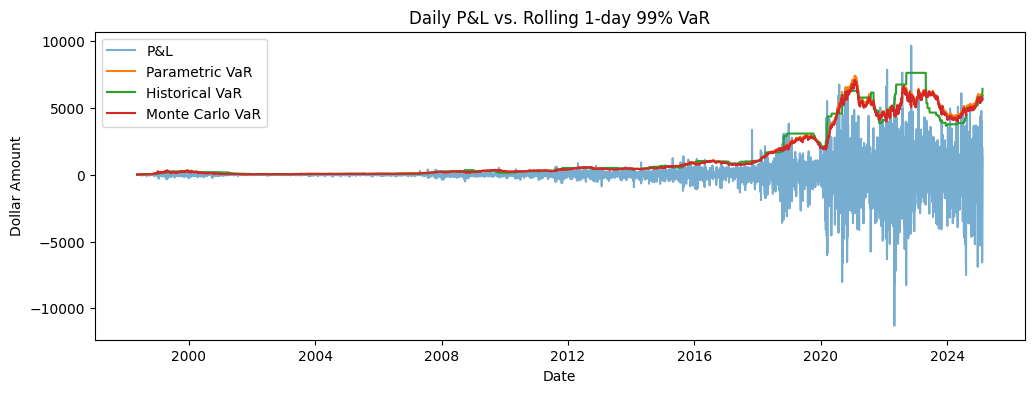

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(pnl_bt.index,     pnl_bt.values,      alpha=0.6, label="P&L")
plt.plot(param_series.index, param_series.values,  label="Parametric VaR")
plt.plot(hist_series.index,  hist_series.values,   label="Historical VaR")
plt.plot(mc_series.index,    mc_series.values,     label="Monte Carlo VaR")
plt.title("Daily P&L vs. Rolling 1-day 99% VaR")
plt.xlabel("Date"); plt.ylabel("Dollar Amount")
plt.legend(loc="upper left")
plt.show()


In [7]:
import pandas as pd

summary = pd.DataFrame({
    "Parametric":   compute_exceptions(pnl_bt, param_series).sum(),
    "Historical":   compute_exceptions(pnl_bt, hist_series).sum(),
    "Monte Carlo":  compute_exceptions(pnl_bt, mc_series).sum()
}, index=["Exceptions"]).T

summary["Exception Rate"] = (summary["Exceptions"] / len(pnl_bt)).map("{:.2%}".format)
summary["Kupiec LR"]      = [
    kupiec_test(compute_exceptions(pnl_bt, s), P_VAR)[0]
    for s in [param_series, hist_series, mc_series]
]
summary["p-value"] = summary["Kupiec LR"].apply(lambda LR: chi2.sf(LR,1))\
                                      .map("{:.3e}".format)

summary


,Exceptions,Exception Rate,Kupiec LR,p-value
Parametric,123,1.83%,37.410887,9.569e-10
Historical,143,2.12%,65.017098,7.425e-16
Monte Carlo,157,2.33%,87.797957,7.249e-21
